# HR Analytics

### Main purpose of this notebook is to be able to predict employee attrition and fair compensation value.

### Contents:
- EDA and visualizations
- Correlation analysis
- Modelling
    - Linear Regression for predicting salary
    - Tree based classifiers for predictiong attrition
    - Fine-tune best model
    - Feature importance
- Predicting current employees at risk of leaving
- Conclusions

#### Imports

In [1]:
# Standard library imports
import os
import time
from collections import Counter

# Related third party imports
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import psycopg2
import seaborn as sns
from dotenv import load_dotenv
from scipy.stats import ttest_ind, chi2_contingency

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    average_precision_score,
    balanced_accuracy_score,
    classification_report,
    confusion_matrix,
    matthews_corrcoef,
    roc_auc_score,
)
from sklearn.preprocessing import (
    LabelEncoder,
    MinMaxScaler,
    RobustScaler,
    StandardScaler,
)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Local application/library specific imports
from helpers import *

In [2]:
import warnings

warnings.filterwarnings("ignore")

start = "\033[1m"  # Bold text
end = "\033[0;0m"  # Reset text

In [3]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

# https://www.kaggle.com/questions-and-answers/118932
# Max rows and columns of pandas dataframe
pd.options.display.max_rows, pd.options.display.max_columns

# https://thispointer.com/python-pandas-how-to-display-full-dataframe-i-e-print-all-rows-columns-without-truncation/
# Print all the contents of a pandas dataframe
pd.set_option(
    "display.max_rows", None
)  # Print unlimited number of rows by setting to None, default is 10
pd.set_option(
    "display.max_columns", None
)  # Do not truncate columns to display all of them by setting to None
pd.set_option(
    "display.width", None
)  # Auto-detect the width of dataframe to display all columns in single line by setting to None
pd.set_option(
    "display.max_colwidth", None
)  # Auto detect the max size of column and print contents of that column without truncation

#### Get the data from db

In [4]:
# load_dotenv()

# # Retrieve environment variables
# DB_HOST = os.getenv("DB_HOST")
# DB_NAME = os.getenv("DB_NAME")
# DB_USER = os.getenv("DB_USER")
# DB_PASSWORD = os.getenv("DB_PASSWORD")

# # Connect to your postgres DB
# conn = psycopg2.connect(
#     host=DB_HOST, database=DB_NAME, user=DB_USER, password=DB_PASSWORD
# )

# # Open a cursor to perform database operations
# cur = conn.cursor()

# # Execute a query
# cur.execute("SELECT * FROM hr_data")

# # Fetch all rows from the table
# rows = cur.fetchall()

# # Get the column names
# column_names = [desc[0] for desc in cur.description]

# # Create a DataFrame from the rows and column names
# df = pd.DataFrame(rows, columns=column_names)

# # Close communication with the database
# cur.close()
# conn.close()

# # Display the DataFrame
# df.head()

# del cur, conn, DB_HOST, DB_NAME, DB_USER, DB_PASSWORD, rows, column_names

df = pd.read_csv('data/analytics_data.csv')

In [5]:
df.rename(columns={"average_montly_hours": "average_monthly_hours"}, inplace=True)
df.rename(columns={"time_spend_company": "tenure"}, inplace=True)
df.rename(columns={"salary": "salary_usd"}, inplace=True)

#### Understanding the HR dataset

Variable  |Description |
-----|-----|
satisfaction_level|Employee-reported job satisfaction level [0&ndash;1]|
last_evaluation|Score of employee's last performance review [0&ndash;1]|
number_project|Number of projects employee contributes to|
average_monthly_hours|Average number of hours employee worked per month|
time_spend_company|How long the employee has been with the company (years)
Work_accident|Whether or not the employee experienced an accident while at work
left|Whether or not the employee left the company
promotion_last_5years|Whether or not the employee was promoted in the last 5 years
Department|The employee's department
salary|The employee's salary (U.S. dollars)

### Initial EDA and data cleaning

In [6]:
print(start + "Data Information post data type change:" + end)
df.info()

Data Information post data type change:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             14999 non-null  int64  
 1   satisfaction_level     14999 non-null  float64
 2   last_evaluation        14999 non-null  float64
 3   number_project         14999 non-null  int64  
 4   average_monthly_hours  14999 non-null  int64  
 5   tenure                 14999 non-null  int64  
 6   work_accident          14999 non-null  int64  
 7   left                   14999 non-null  int64  
 8   promotion_last_5years  14999 non-null  int64  
 9   department             14999 non-null  object 
 10  salary_usd             14999 non-null  int64  
dtypes: float64(2), int64(8), object(1)
memory usage: 1.3+ MB


In [7]:
print(start + "Number of missing rows per column" + end)
df.isnull().sum()

Number of missing rows per column


Unnamed: 0               0
satisfaction_level       0
last_evaluation          0
number_project           0
average_monthly_hours    0
tenure                   0
work_accident            0
left                     0
promotion_last_5years    0
department               0
salary_usd               0
dtype: int64

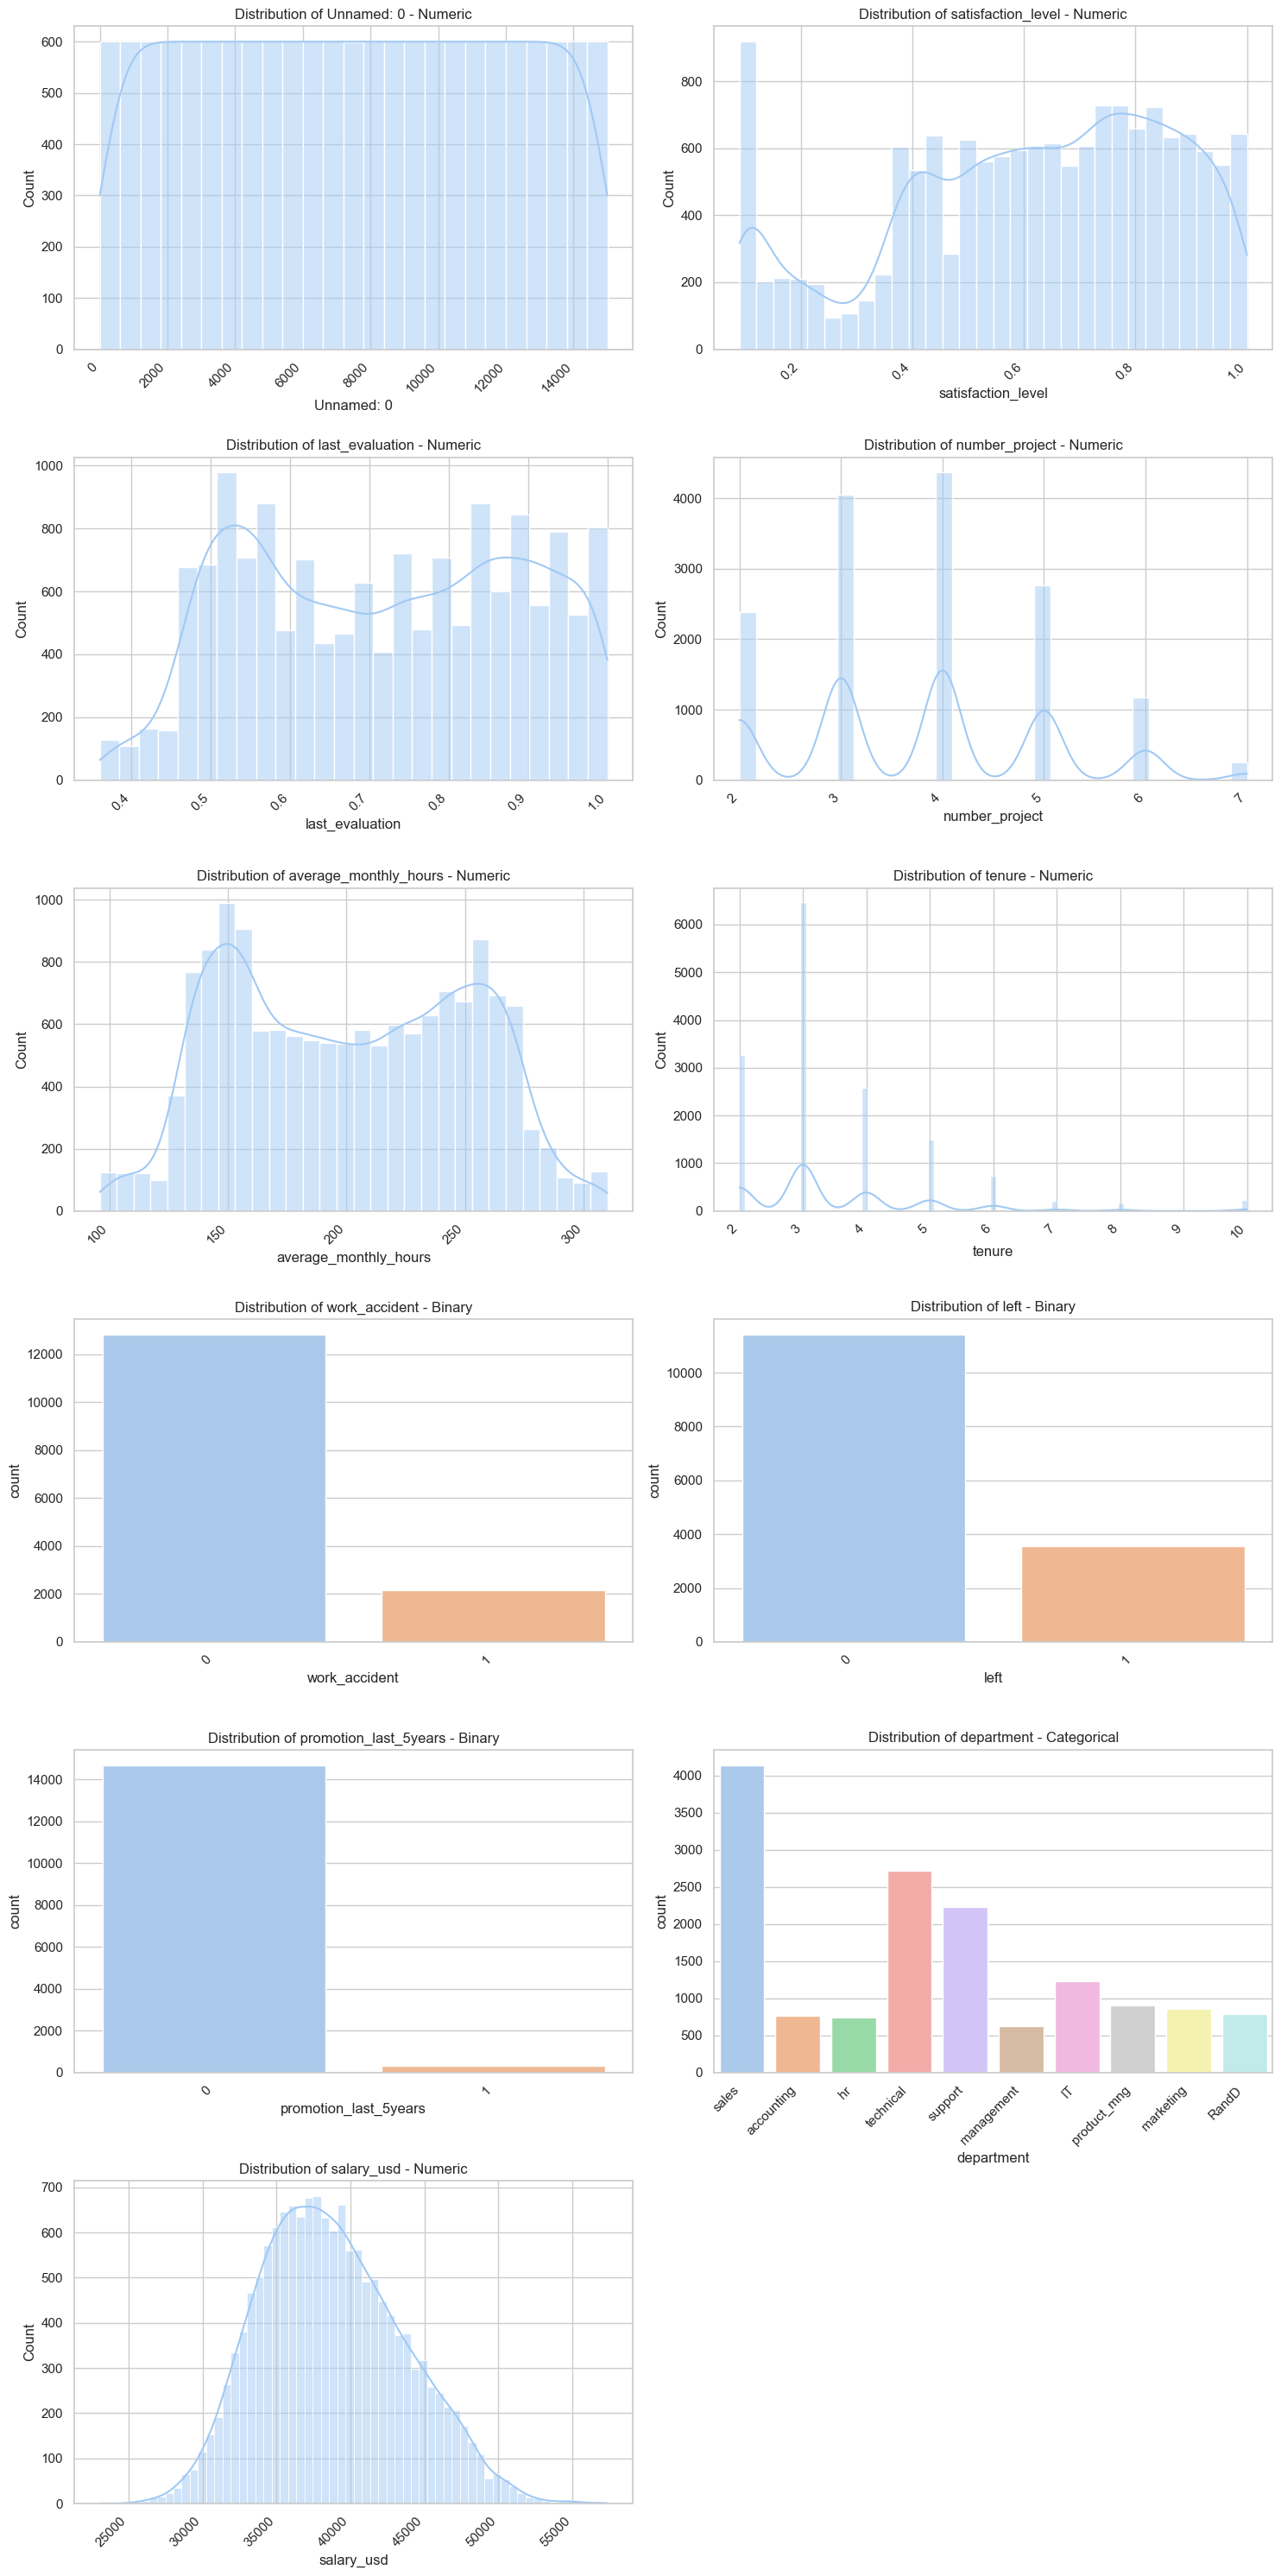

In [8]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")
sns.set_palette("pastel")
plot_data(df)

Initial observations of the data:
* About 14% of employees have experienced a work accident
* Almost 98% of employees did not recieve a promotion in the last 5 years
* Almost 24% of employees have left the company
* Majority of people have low and medium salaries

In [9]:
print(start + "Encoding salaries from low, medium, high to 0, 1, 2" + end)
df["salary"] = pd.qcut(df["salary_usd"], 3, labels=False)
df.head()

Encoding salaries from low, medium, high to 0, 1, 2


,Unnamed: 0,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary_usd,salary
0,0,0.38,0.53,2,157,3,0,1,0,sales,35391,0
1,1,0.80,0.86,5,262,6,0,1,0,sales,46254,2
2,2,0.11,0.88,7,272,4,0,1,0,sales,47519,2
3,3,0.72,0.87,5,223,5,0,1,0,sales,46957,2
4,4,0.37,0.52,2,159,3,0,1,0,sales,33664,0


In [10]:
df.describe()

,Unnamed: 0,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary_usd,salary
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,7499.000000,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268,38727.376692,0.999733
std,4329.982679,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281,4847.726306,0.816551
min,0.000000,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000,23043.000000,0.000000
25%,3749.500000,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000,35162.500000,0.000000
50%,7499.000000,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000,38309.000000,1.000000
75%,11248.500000,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000,42001.000000,2.000000
max,14998.000000,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000,57365.000000,2.000000


#### Check for any missing values in the data.

In [11]:
df.isnull().sum()

Unnamed: 0               0
satisfaction_level       0
last_evaluation          0
number_project           0
average_monthly_hours    0
tenure                   0
work_accident            0
left                     0
promotion_last_5years    0
department               0
salary_usd               0
salary                   0
dtype: int64

#### Check duplicates

In [12]:
df.duplicated().sum()

0

#### Check outliers

In [13]:
numeric_columns = df.select_dtypes(include=["number"])
outlier_df = display_outlier_percentage(numeric_columns)
outlier_df.sort_values(by="Percentage", ascending=False)

,Number of Outliers,Percentage
left,3571,23.808254
work_accident,2169,14.460964
tenure,1282,8.547236
promotion_last_5years,319,2.126808
salary_usd,46,0.306687
Unnamed: 0,0,0.000000
satisfaction_level,0,0.000000
last_evaluation,0,0.000000
number_project,0,0.000000
average_monthly_hours,0,0.000000


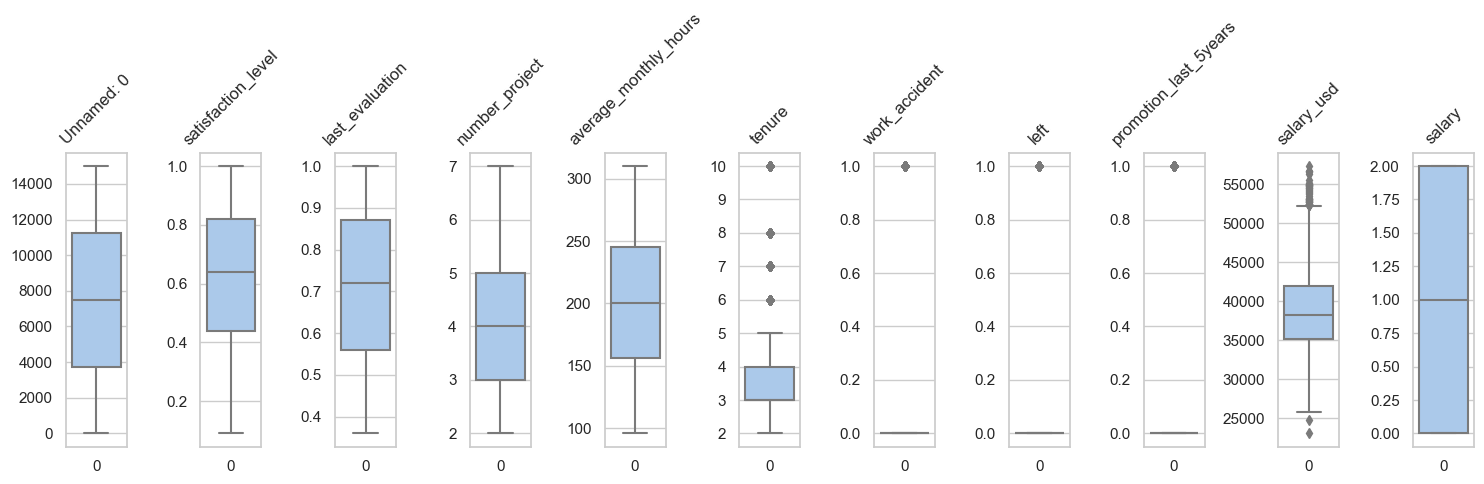

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=len(numeric_columns.columns), figsize=(15, 5))
for i, column in enumerate(numeric_columns.columns):
    ax = sns.boxplot(data=numeric_columns[column], ax=axes[i])
    axes[i].set_title(f"{column}", rotation=45)

plt.tight_layout()
plt.show();

##### Tenure

In [15]:
fig = px.box(df, x="tenure", orientation="h")

# Update the layout of the figure
fig.update_layout(
    title="Distribution of Tenure",
    title_x=0.5,  # Center the title
    xaxis=dict(dtick=1),  # Increment the x-axis by one unit
    xaxis_title="Tenure (years)",
    yaxis_title="",
    height=400,  # Adjust the height
    width=600,  # Adjust the width)
)
del fig

In [16]:
Q1 = df["tenure"].quantile(0.25)
Q3 = df["tenure"].quantile(0.75)
IQR = Q3 - Q1
lower_fence = Q1 - 1.5 * IQR
upper_fence = Q3 + 1.5 * IQR

# Count the number of rows containing outliers
num_outliers = len(df[(df["tenure"] < lower_fence) | (df["tenure"] > upper_fence)])

# Print the result
print(start + "Number of rows containing outliers for tenure:", str(num_outliers) + end)

del Q1, Q3, IQR, lower_fence, upper_fence, num_outliers

Number of rows containing outliers for tenure: 1282


In [17]:
df.head(10)

,Unnamed: 0,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary_usd,salary
0,0,0.38,0.53,2,157,3,0,1,0,sales,35391,0
1,1,0.80,0.86,5,262,6,0,1,0,sales,46254,2
2,2,0.11,0.88,7,272,4,0,1,0,sales,47519,2
3,3,0.72,0.87,5,223,5,0,1,0,sales,46957,2
4,4,0.37,0.52,2,159,3,0,1,0,sales,33664,0
5,5,0.41,0.50,2,153,3,0,1,0,sales,33364,0
6,6,0.10,0.77,6,247,4,0,1,0,sales,47698,2
7,7,0.92,0.85,5,259,5,0,1,0,sales,46868,2
8,8,0.89,1.00,5,224,5,0,1,0,sales,42026,2
9,9,0.42,0.53,2,142,3,0,1,0,sales,34756,0


### Correlation analysis

In [18]:
# Get numbers of people who left vs. stayed
print(start + "Number of people who left vs. stayed" + end)
df["left"].value_counts()

Number of people who left vs. stayed


left
0    11428
1     3571
Name: count, dtype: int64

In [19]:
# Create a plot as needed
numeric_df = df.select_dtypes(include=[np.number])  # type: ignore
numeric_df.drop(columns=["salary"], inplace=True)
correlation_matrix = numeric_df.corr()

mask = np.tril(np.ones_like(correlation_matrix, dtype=bool))
masked_correlation = correlation_matrix.where(~mask)

# Create heatmap for the upper triangular part
fig_upper = ff.create_annotated_heatmap(
    z=masked_correlation.values,
    x=list(masked_correlation.columns),
    y=list(masked_correlation.index),
    annotation_text=masked_correlation.round(2).values,
    colorscale="RdBu",
    reversescale=True,
    showscale=True,
)

# Update layout
fig_upper.update_layout(title="")

del fig_upper

There are some important correlations to be noted:
1. salary_usd with 66% positive correlation with average monthly hours, 58% with tenure and 54% with number_project
2. left and satisfaction_level: -35% negative correlation
3. average_monthy_hours and number_project : 33.1% correlated
4. number_project and last_evaluation: 27% correlated
5. average_monthly_hours and last_evaluation: 26% correlated

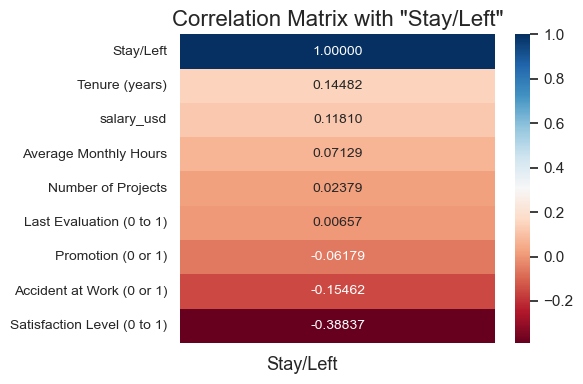

In [20]:
vars_lst = [
    "satisfaction_level",
    "last_evaluation",
    "number_project",
    "average_monthly_hours",
    "tenure",
    "work_accident",
    "promotion_last_5years",
    "salary_usd",
]

corr_matrix = df[vars_lst + ["left"]].corr()

# Sort the correlation values in descending order
corr_sorted = corr_matrix["left"].sort_values(ascending=False)

plt.figure(figsize=(6, 4))
sns.heatmap(
    pd.DataFrame(corr_sorted),
    annot=True,
    cmap="RdBu",
    annot_kws={"size": 10},
    fmt=".5f",
)

label_map = {
    "satisfaction_level": "Satisfaction Level (0 to 1)",
    "last_evaluation": "Last Evaluation (0 to 1)",
    "number_project": "Number of Projects",
    "average_monthly_hours": "Average Monthly Hours",
    "tenure": "Tenure (years)",
    "work_accident": "Accident at Work (0 or 1)",
    "promotion_last_5years": "Promotion (0 or 1)",
    "salary_encoded": "Salary (0,1,2)",
    "left": "Stay/Left",
}

ax = plt.gca()
ax.set_xticklabels(["Stay/Left"], ha="right", fontsize=13)
ax.set_yticklabels(
    [label_map.get(var, var) for var in corr_sorted.index], rotation=0, fontsize=10
)
del corr_matrix, label_map, ax
plt.title('Correlation Matrix with "Stay/Left"', fontsize=16)

plt.tight_layout()
plt.show();

Interpretation:
- Tenure: The correlation of 0.14 indicates that there is a weak tendancy for people that have been with the company for a long time to leave.
- Satisfaction level: The negative correlation of -0.38 indicates that less satisfied employees are more likely to leave. However, this is not a very strong inverse correlation.

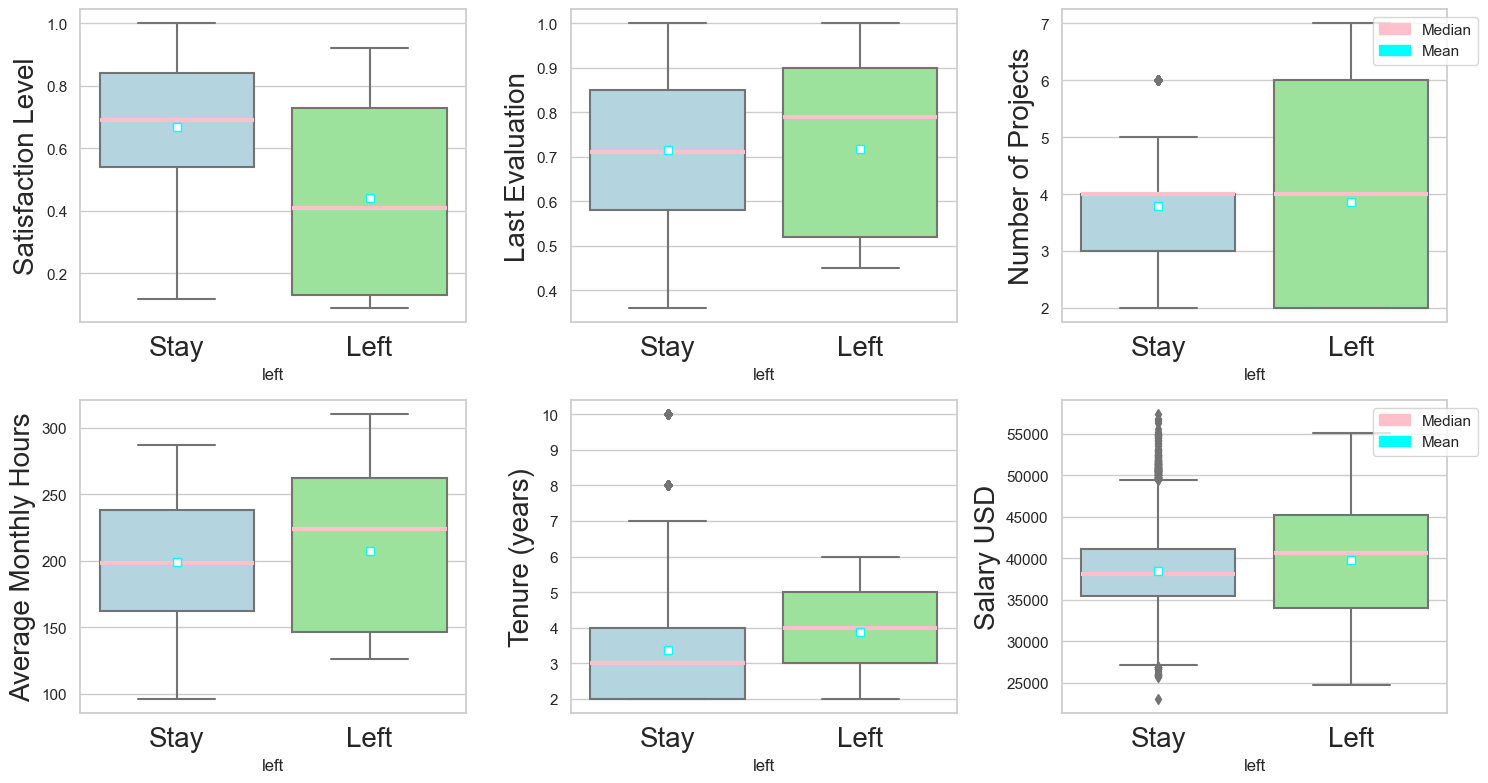

In [21]:
# Setting the style for seaborn
sns.set_style("whitegrid")

# Create the figure and axes for subplot
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

numeric_lst = [
    "satisfaction_level",
    "last_evaluation",
    "number_project",
    "average_monthly_hours",
    "tenure",
    "salary_usd",
]
y_axis = [
    "Satisfaction Level",
    "Last Evaluation",
    "Number of Projects",
    "Average Monthly Hours",
    "Tenure (years)",
    "Salary USD",
]
median_patch = mpatches.Patch(color="pink", label="Median")
mean_patch = mpatches.Patch(color="Cyan", label="Mean")

for idx, feature in enumerate(numeric_lst):
    # Determine the subplot indices
    row_idx = idx // 3
    col_idx = idx % 3

    # Using seaborn to create the boxplots
    sns.boxplot(
        x="left",
        y=feature,
        data=df,
        ax=ax[row_idx, col_idx],
        palette=["lightblue", "lightgreen"],
        showmeans=True,
        meanprops={
            "marker": "s",
            "markerfacecolor": "white",
            "markeredgecolor": "Cyan",
        },
        medianprops={"color": "pink", "linewidth": 3},
    )

    # Setting the y-axis label and x-axis labels
    ax[row_idx, col_idx].set_ylabel(y_axis[idx], size=20)
    ax[row_idx, col_idx].set_xticklabels(["Stay", "Left"], size=20)

    # Check if there are any artists for median
    median_artists = ax[row_idx, col_idx].artists
    median_line = median_artists[0] if median_artists else None

    # Check if there are any lines for mean
    mean_lines = [
        line
        for line in ax[row_idx, col_idx].get_lines()
        if line.get_markerfacecolor() == "white"
    ]
    mean_line = mean_lines[0] if mean_lines else None

    # Create legend only if median and mean are present
    if median_line and mean_line:
        ax[row_idx, col_idx].legend(
            [median_line, mean_line],
            ["Median", "Mean"],
            loc="upper right",
        )
    if col_idx == 2:  # This assumes there are 3 columns
        ax[row_idx, col_idx].legend(
            handles=[median_patch, mean_patch],
            loc="upper right",
            bbox_to_anchor=(1.1, 1),
        )


plt.tight_layout()
plt.show();

In [22]:
pdf = df.copy()
pdf.drop(
    ["work_accident", "promotion_last_5years", "department", "salary_usd"],
    axis=1,
    inplace=True,
)
pdf = (
    pd.concat(
        [
            pdf,
            df.drop(
                ["work_accident", "promotion_last_5years", "department", "salary_usd"],
                axis=1,
            ),
        ],
        ignore_index=True,
    )
    .groupby("left")
    .describe()
    .sort_index()
)

pdf = pdf.unstack().unstack(1).sort_index(level=[0, 1])
pdf = pdf[["count", "mean", "std", "min", "25%", "50%", "75%", "max"]]
sumstatsfmt(pdf)

n       Mean         SD  Min         Q1  \
                      left                                                 
Unnamed: 0            Stay  22,856  7,811.243  3,454.630  634  4,856.750   
                      Left   7,142  6,499.754  6,264.774    0    893.250   
Average Monthly Hours Stay  22,856    199.060     45.682   96    162.000   
                      Left   7,142    207.419     61.199  126    146.000   
Last Evaluation       Stay  22,856      0.715      0.162    0      0.580   
                      Left   7,142      0.718      0.198    0      0.520   
Number of Projects    Stay  22,856      3.787      0.980    2      3.000   
                      Left   7,142      3.856      1.818    2      2.000   
salary                Stay  22,856      0.963      0.773    0      0.000   
                      Left   7,142      1.118      0.932    0      0.000   
Satisfaction Level    Stay  22,856      0.667      0.217    0      0.540   
                      Left   7,142      0.440      0.264    0      0.130   
Tenure (years)        Stay  22,856      3.380      1.562    2      2.000   
                      Left   7,142      3.877      0.978    2      3.000   

                               Median          Q3     Max  
                      left                                 
Unnamed: 0            Stay  7,713.500  10,570.250  14,212  
                      Left  1,789.000  12,677.750  14,998  
Average Monthly Hours Stay    198.000     238.000     287  
                      Left    224.000     262.000     310  
Last Evaluation       Stay      0.710       0.850       1  
                      Left      0.790       0.900       1  
Number of Projects    Stay      4.000       4.000       6  
                      Left      4.000       6.000       7  
salary                Stay      1.000       2.000       2  
                      Left      1.000       2.000       2  
Satisfaction Level    Stay      0.690       0.840       1  
                      Left      0.410       0.730       1  
Tenure (years)        Stay      3.000       4.000      10  
                      Left      4.000       5.000       6

Which of these differences are statistically significant?

In [23]:
p_values = {}

for feature in numeric_lst:
    group_stay = df[df["left"] == 0][feature]
    group_left = df[df["left"] == 1][feature]

    t_stat, p_val = ttest_ind(group_stay, group_left, equal_var=True)
    p_values[feature] = p_val

p_value_df = pd.DataFrame(
    {
        "Numerical features": numeric_lst,
        "p-value": [p_values[feature] for feature in numeric_lst],
        "statistically significant (a = 0.05)": [
            p_values[feature] < 0.05 for feature in numeric_lst
        ],
    }
)

p_value_df.set_index("Numerical features", inplace=True)
p_value_df.sort_values(["p-value"])

,p-value,statistically significant (a = 0.05)
Numerical features,,
satisfaction_level,0.000000e+00,True
tenure,4.207680e-71,True
salary_usd,1.000342e-47,True
average_monthly_hours,2.311304e-18,True
number_project,3.575214e-03,True
last_evaluation,4.212702e-01,False


### Comparing the characteristics of employees who left with those who stayed. Here are the key findings:

- **Satisfaction Level:**  There is a statistically significant difference in the satisfaction levels of employees who left and those who stayed. Employees who left the company tend to have a lower satisfaction level.
- **Tenure (years):** There's a statistically significant difference in tenure between the groups. Employees who left have slightly higher tenure compared to those who stayed.
- **Salary Level:** There's a significant difference in the salary levels of the two groups.
- **Average Monthly Hours**: Employees who left tend to work more hours on average, and this difference is statistically significant.
- **Number of Projects**:  Employees who left have a statistically significant difference in the number of projects they were involved in.
- **Last Evaluation:** While there's a slight difference in the last evaluation scores between the two groups, this difference is not statistically significant. This suggests that the quality of work (as measured by the last evaluation) might not be a strong predictor for an employee's decision to leave.

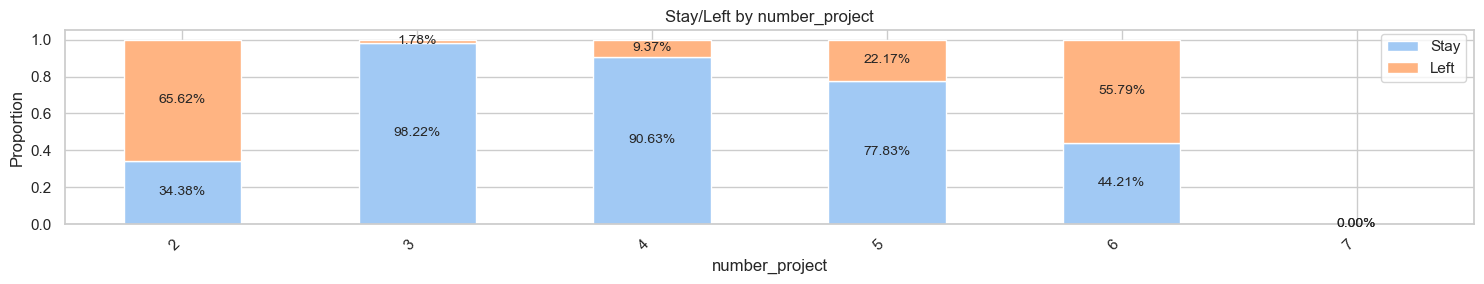

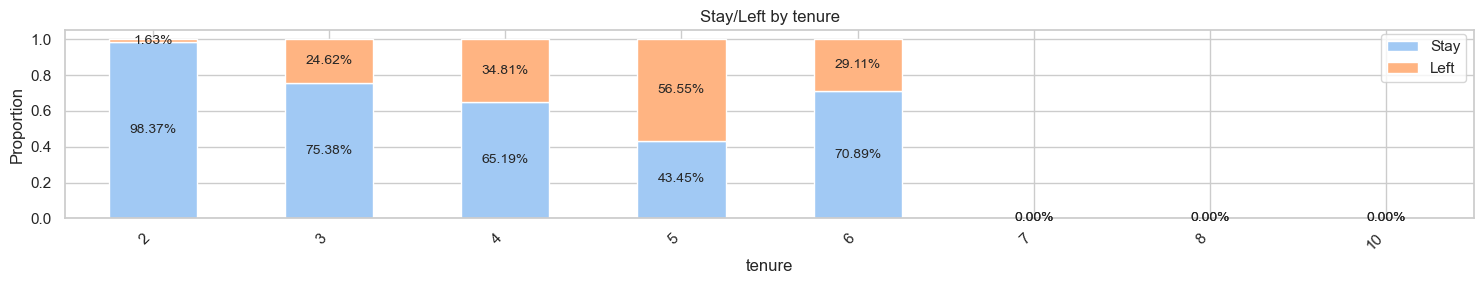

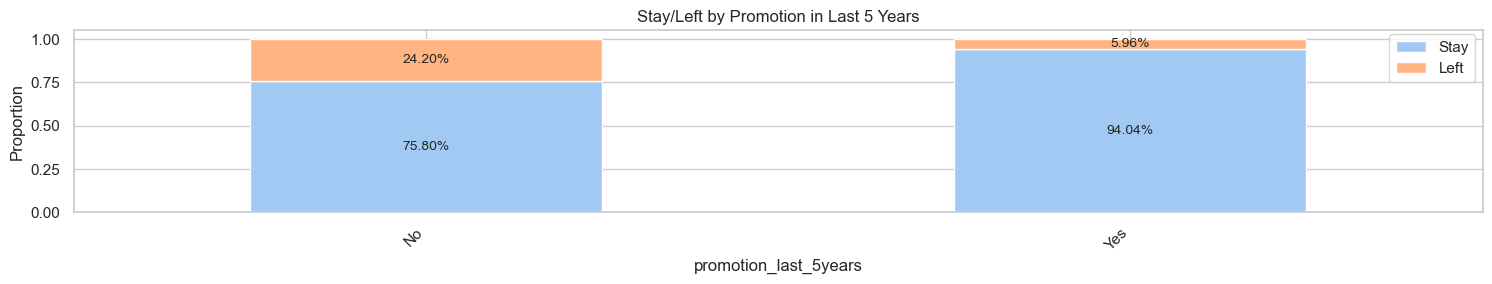

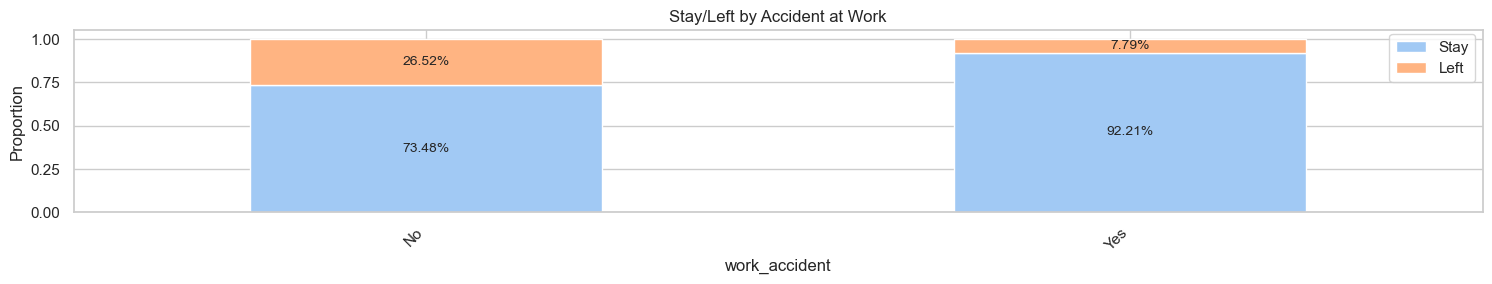

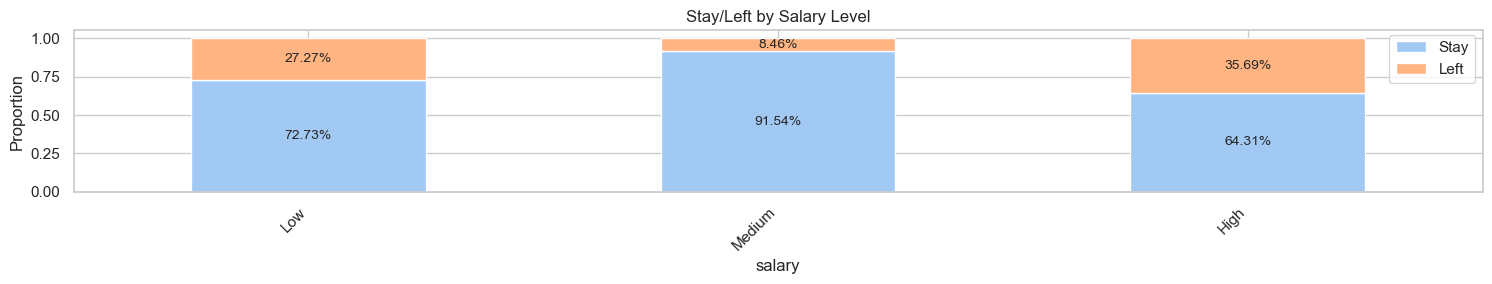

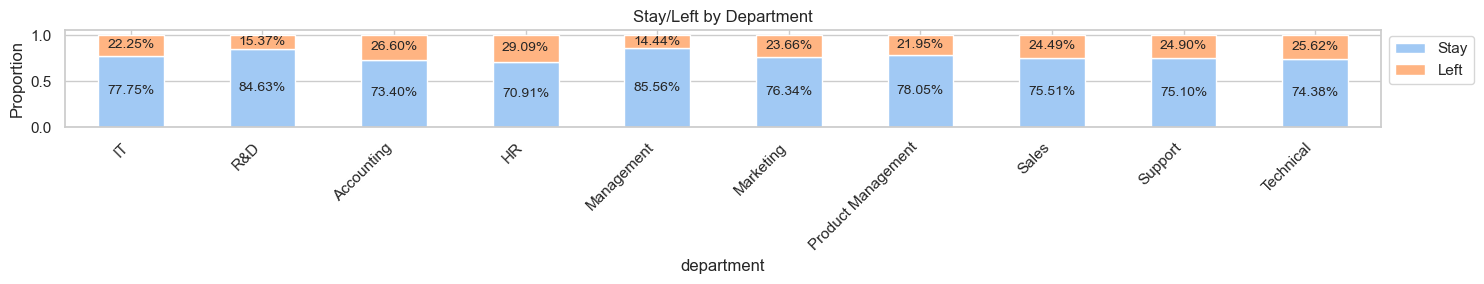

In [24]:
# Mapping dictionaries
vars_list = [
    "number_project",
    "tenure",
    "promotion_last_5years",
    "work_accident",
    "salary",
    "department",
]
department_labels = {
    "sales": "Sales",
    "technical": "Technical",
    "support": "Support",
    "IT": "IT",
    "product_mng": "Product Management",
    "marketing": "Marketing",
    "RandD": "R&D",
    "accounting": "Accounting",
    "hr": "HR",
    "management": "Management",
}
binary_labels = {0: "No", 1: "Yes"}
salary_labels = {0: "Low", 1: "Medium", 2: "High"}

# Labels for variables
var_labels = {
    "department": department_labels,
    "work_accident": binary_labels,
    "promotion_last_5years": binary_labels,
    "salary": salary_labels,
}
# Human-readable labels for variables
var_titles = {
    "department": "Department",
    "work_accident": "Accident at Work",
    "promotion_last_5years": "Promotion in Last 5 Years",
    "salary": "Salary Level",
}
for var in vars_list:
    labels_map = var_labels.get(var, {})
    title = "Stay/Left by " + var_titles.get(var, var)
    plot_attrition_by_variable(df, var, labels_map, title)

In [25]:
import logging

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)

perform_chi_square_test(df, "number_project", "left", 0.05)
perform_chi_square_test(df, "tenure", "left", 0.05)
perform_chi_square_test(df, "work_accident", "left", 0.05)
perform_chi_square_test(df, "salary", "left", 0.05)
perform_chi_square_test(df, "department", "left", 0.05)

2023-12-30 14:57:04,282 - INFO - p-value: 0.0 : The difference in proportions between number_project and left is statistically significant.
2023-12-30 14:57:04,293 - INFO - p-value: 0.0 : The difference in proportions between tenure and left is statistically significant.
2023-12-30 14:57:04,297 - INFO - p-value: 9.55823958002199e-80 : The difference in proportions between work_accident and left is statistically significant.
2023-12-30 14:57:04,297 - INFO - p-value: 2.3223449753167188e-233 : The difference in proportions between salary and left is statistically significant.
2023-12-30 14:57:04,309 - INFO - p-value: 7.042130463822518e-15 : The difference in proportions between department and left is statistically significant.


### Findings
- All the variables except last_evaluation are statistically significant between employees who left vs those that stayed. 
- Surprisingly, the proportion of employees leaving is lower for those who had an accident at work (5.68%) compared to those who did not (18.60%).
- The proportion of employees leaving is lower for those who received a promotion in the last five years i.e. 3.94% compared to those who did not receive a promotion i.e. 16.82%.
- The proportion of employees leaving is the lowest among the high salary group i.e. 4.85%, followed by the medium salary group i.e. 14.62% and the low salary group i.e. 20.45%. This relationship is also depicted in the previous boxplot visualization of salary.

-> Plotting evaluation of employees based on wether they left or not and the average number of working hours

-> Plotting satisfaction of employees based on wether they left or not and the average number of working hours

### Overtime analysis

In [26]:
df.head()

,Unnamed: 0,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary_usd,salary
0,0,0.38,0.53,2,157,3,0,1,0,sales,35391,0
1,1,0.80,0.86,5,262,6,0,1,0,sales,46254,2
2,2,0.11,0.88,7,272,4,0,1,0,sales,47519,2
3,3,0.72,0.87,5,223,5,0,1,0,sales,46957,2
4,4,0.37,0.52,2,159,3,0,1,0,sales,33664,0


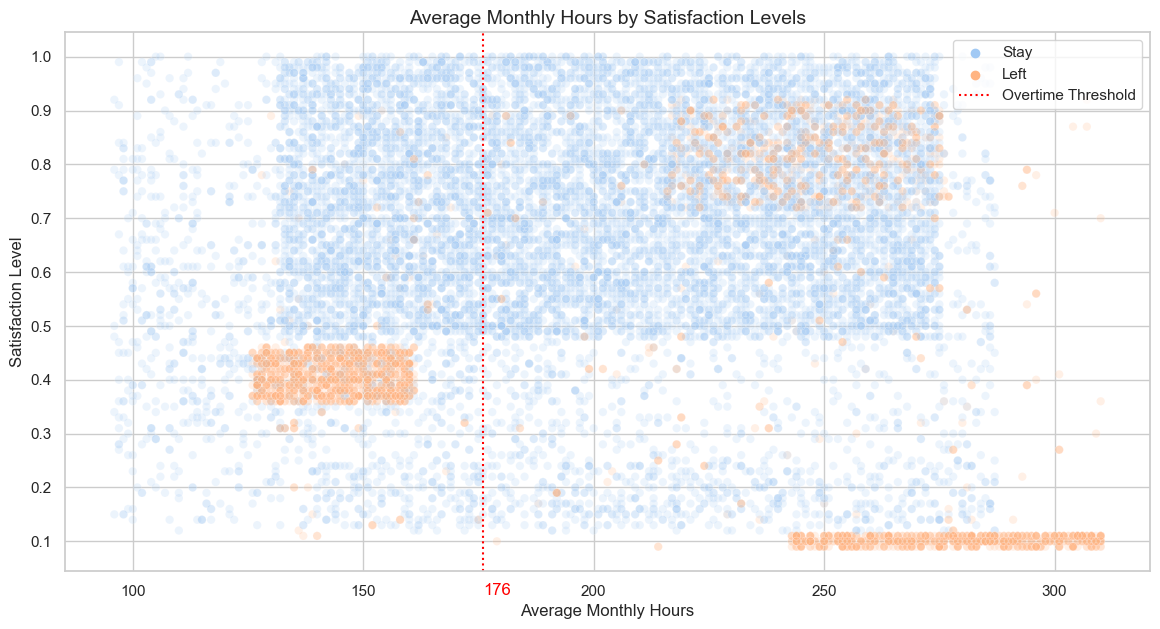

In [27]:
generate_scatterplt(
    df,
    "average_monthly_hours",
    "satisfaction_level",
    "Average Monthly Hours",
    "Satisfaction Level",
    "Average Monthly Hours by Satisfaction Levels",
    176,
    0,
)

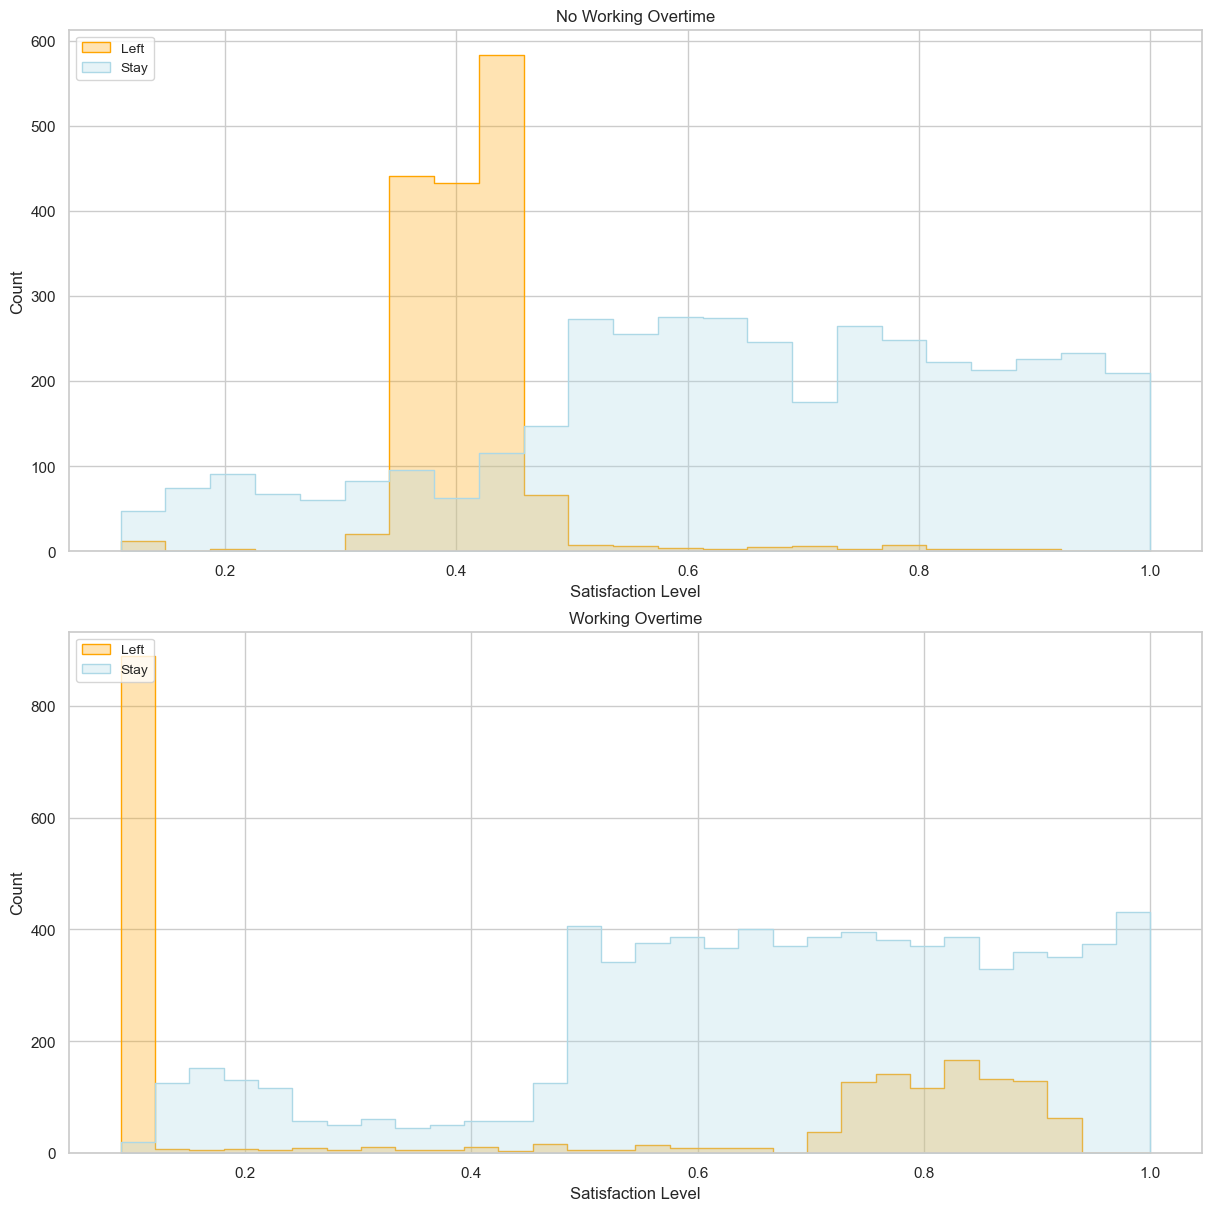

In [28]:
# Call the main function to create histograms
threshold_value = 176
feature_to_evaluate = "average_monthly_hours"
target_column = "left"
colors = ["lightblue", "orange"]
create_overtime_histograms(
    df, threshold_value, feature_to_evaluate, target_column, colors
)

In [29]:
df.head()

,Unnamed: 0,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary_usd,salary,overtime
0,0,0.38,0.53,2,157,3,0,1,0,sales,35391,0,0
1,1,0.80,0.86,5,262,6,0,1,0,sales,46254,2,1
2,2,0.11,0.88,7,272,4,0,1,0,sales,47519,2,1
3,3,0.72,0.87,5,223,5,0,1,0,sales,46957,2,1
4,4,0.37,0.52,2,159,3,0,1,0,sales,33664,0,0


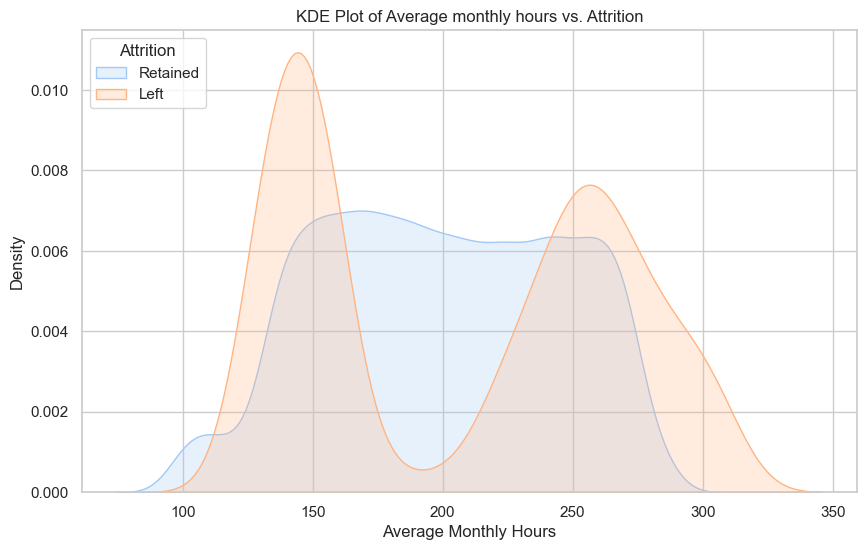

In [30]:
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=df[df["left"] == 0]["average_monthly_hours"], label="Retained", fill=True
)
sns.kdeplot(data=df[df["left"] == 1]["average_monthly_hours"], label="Left", fill=True)
plt.title("KDE Plot of Average monthly hours vs. Attrition")
plt.xlabel("Average Monthly Hours")
plt.ylabel("Density")
plt.legend(title="Attrition", loc="upper left", labels=["Retained", "Left"])
plt.show();

From the histograms, we can observe the distribution of satisfaction levels among employees based on whether they worked overtime and whether they stayed with the company or left.
- Employees not working overtime tend to leave when their satisfaction level is around 0.4.
- Among those doing overtime, two groups are prominent: one with very low satisfaction and another around a 0.8 satisfaction level, both showing a higher likelihood to quit.

# Modelling

#### Linear Regression for predicting salary

##### Assumptions
- **Linearity**: The relationship between the predictors and the target variable should be linear. We'll use scatter plots for some of the continuous variables against the 'salary_usd' to visually inspect linearity.

- **Homoscedasticity**: The residuals (differences between observed and predicted values) should have constant variance.

- **Normality** of Residuals: The residuals should be normally distributed.

- **Independence** of Residuals: Residuals should be independent of each other.



In [31]:
data = pd.get_dummies(df, drop_first=True)

model, selected_features = backward_elimination(data, 'salary_usd')
selected_features.remove('salary')
print(f"Selected features: {selected_features}")
print(model.summary())

Selected features: ['number_project', 'average_monthly_hours', 'tenure', 'left', 'overtime']
                            OLS Regression Results                            
Dep. Variable:             salary_usd   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                 1.699e+04
Date:                Sat, 30 Dec 2023   Prob (F-statistic):               0.00
Time:                        14:57:05   Log-Likelihood:            -1.3316e+05
No. Observations:               14999   AIC:                         2.663e+05
Df Residuals:                   14992   BIC:                         2.664e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Create dummy variables for all categorical columns at once
data = pd.get_dummies(df, drop_first=True)

# Splitting the data into features and target variable
# Assuming 'salary' is another column you want to exclude from features
X = data[selected_features]
y = data['salary_usd']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"R-squared: {r2}, RMSE: {rmse}")

LinearRegression()

R-squared: 0.7390454428056037, RMSE: 2504.807841306232


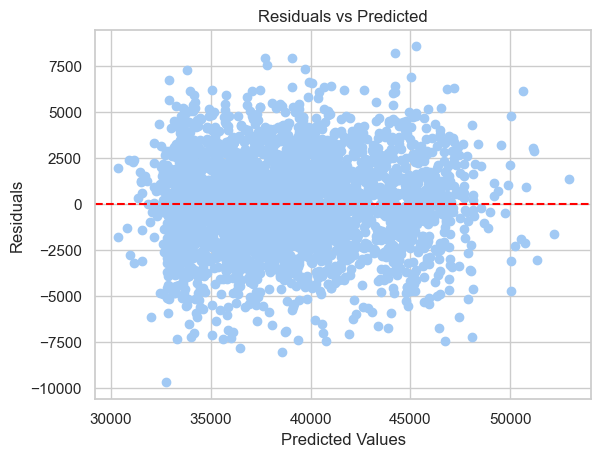

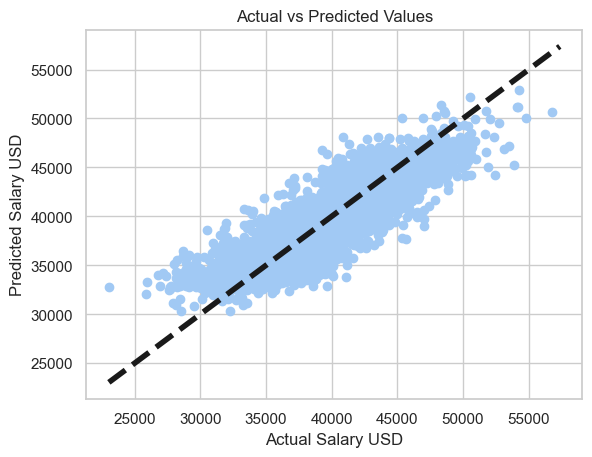

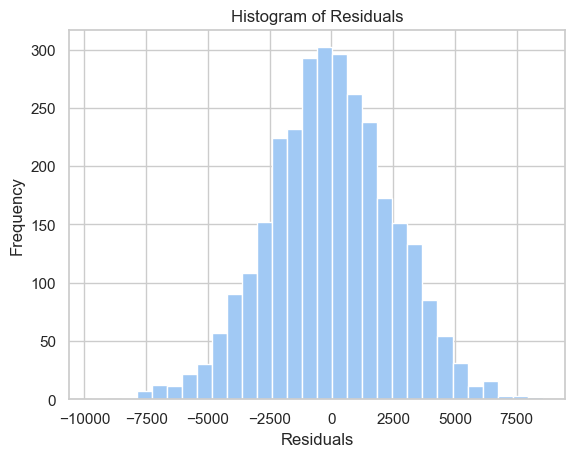

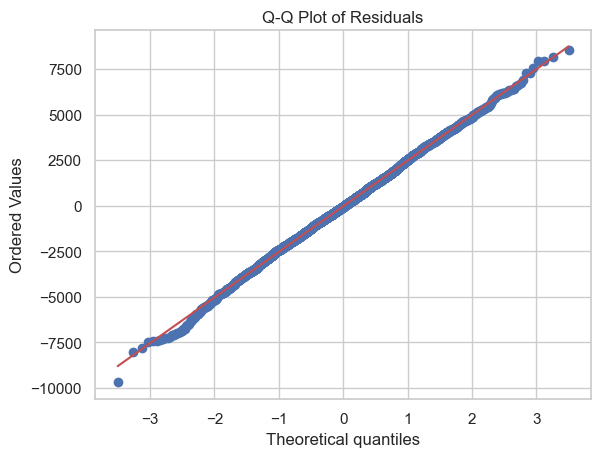

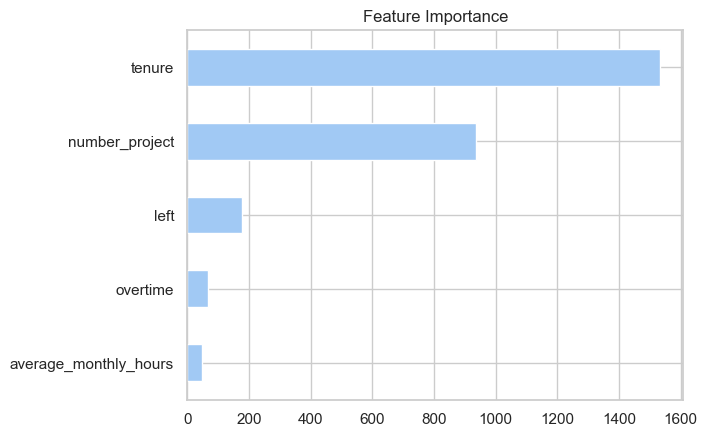

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot

# Residuals Plot
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.title("Residuals vs Predicted")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.axhline(y=0, color="red", linestyle="--")
plt.show()

# Predicted vs Actual Values Plot
plt.scatter(y_test, y_pred)
plt.title("Actual vs Predicted Values")
plt.xlabel("Actual Salary USD")
plt.ylabel("Predicted Salary USD")
plt.plot([y.min(), y.max()], [y.min(), y.max()], "k--", lw=4)
plt.show();

# Residuals Histogram
plt.hist(residuals, bins=30)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show();

# Q-Q Plot
probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show();

feature_importance = pd.Series(model.coef_, index=X_train.columns).sort_values(key=abs)
feature_importance.plot(kind="barh")
plt.title("Feature Importance")
plt.show();

In [34]:
alpha = 0.05

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
standard_error = np.sqrt(mse) / np.sqrt(len(X_test))

# Get the critical value from the t-distribution
t_critical = stats.t.ppf(
    1 - alpha / 2, df=len(X_test) - 2
) 

margin_of_error = t_critical * standard_error

# Calculate the confidence interval
lower_bound = y_pred - margin_of_error
upper_bound = y_pred + margin_of_error

results_df = pd.DataFrame(
    {
        "Actual": y_test,
        "Predicted": y_pred,
        "Lower 95% CI": lower_bound,
        "Upper 95% CI": upper_bound,
    }
)

# Reset index to match the rows with the original data
results_df.reset_index(drop=True, inplace=True)

# Display the DataFrame
results_df.head()

,Actual,Predicted,Lower 95% CI,Upper 95% CI
0,25867,32019.223392,31929.555441,32108.891344
1,26948,32877.547913,32787.879961,32967.215864
2,39678,38981.470348,38891.802397,39071.138300
3,37368,33630.985953,33541.318001,33720.653904
4,41488,38919.402821,38829.734869,39009.070772


### Linear Regression Conclusions:

- Model Performance: The R-squared value of approximately 0.739 suggests that the model explains about 73.9% of the variance in the salary data, which is a strong level of explanation given the complexity inherent in salary determinations.

- Residual Analysis: The "Residuals vs. Predicted" plot indicates a reasonable spread around the zero line, suggesting that the model's predictions are unbiased on average. However, the slight pattern of increasing spread with higher predicted values hints at heteroscedasticity, implying that the model's precision decreases as salary increases.

- Predictive Accuracy: The "Actual vs. Predicted Values" plot reveals that the model's predictions are generally close to the actual salaries, especially in the middle range of salaries. However, there is visible deviation as the actual salary increases, which may signal that the model is less accurate for higher salary ranges.

- Distribution of Residuals: The histogram and Q-Q plot of residuals display a roughly normal distribution, with some minor deviations in the tails. This slight skewness and the tail behavior observed in the Q-Q plot suggest that extreme values are not as well predicted by the model, potentially affecting the accuracy of predictions and the width of the confidence intervals.

- Feature Importance: The "Feature Importance" plot identifies 'tenure' and 'number_project' as the most significant predictors of salary. This is consistent with domain understanding, as tenure can be associated with increased experience and career progression, which typically results in higher salaries. The number of projects may reflect an employee's level of engagement and responsibility, which also correlates with compensation.

- RMSE: The RMSE of 2504.81 indicates that the typical prediction error is approximately $2,505. While this is a relatively small error in the context of salary predictions, it is still significant and suggests room for improvement in the model's predictive power.

- Confidence Intervals: The wide confidence intervals compared to the actual values, particularly for some predictions, suggest that certain predictions made by the model are associated with substantial uncertainty. This could be addressed by exploring model improvements or alternative modeling approaches.



In [35]:
df.to_csv("data/df.csv", index=False)

### Logistic Regression


**Logistic Regression model assumptions**
- Outcome variable is categorical
- Observations are independent of each other
- No severe multicollinearity among X variables (Variance Inflation Factor)
- No extreme outliers
- Linear relationship between each X variable and the logit of the outcome variable
- Sufficiently large sample size





In [36]:
logistic_regression_assumptions(df, "left")

The outcome variable is binary or categorical.
Ensure that the observations are independent.
                   feature         VIF
0               Unnamed: 0    4.145001
1       satisfaction_level    7.503317
2          last_evaluation   22.647902
3           number_project   16.358464
4    average_monthly_hours   79.129003
5                   tenure   12.077925
6            work_accident    1.177766
7    promotion_last_5years    1.057062
8               salary_usd  131.646985
9                   salary    5.653656
10                overtime    8.809587
11        department_RandD    1.621117
12   department_accounting    1.605308
13           department_hr    1.574984
14   department_management    1.541365
15    department_marketing    1.684912
16  department_product_mng    1.711108
17        department_sales    4.259893
18      department_support    2.756899
19    department_technical    3.134406
Found 674 extreme outliers
The sample size is sufficiently large.


In [37]:
X_train_enc, X_test_enc, y_train, y_test = prepare_data(df, "left")
print_dataset_summary(X_train_enc, X_test_enc, y_train, y_test)

------Summary------
Training set:
11999 entries, 15 columns
Stay = 76.1897%, Left = 23.8103%

Test set:
3000 entries, 15 columns
Stay = 76.2000%, Left = 23.8000%


In [38]:
X_train_enc.head(5)

,satisfaction_level,last_evaluation,work_accident,promotion_last_5years,salary,overtime,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
12896,0.44,0.61,0,0,2,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
12545,0.77,0.91,0,0,2,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
14833,0.10,0.55,0,0,2,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8335,0.61,0.89,0,0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2724,0.56,0.75,0,0,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [39]:
scalers_list = [None, MinMaxScaler, RobustScaler, StandardScaler]
numeric_features_list = [
    "satisfaction_level",
    "last_evaluation",
    "work_accident",
    "promotion_last_5years",
    "salary",
    "overtime",
    "department_RandD",
    "department_accounting",
    "department_hr",
    "department_management",
    "department_marketing",
    "department_product_mng",
    "department_sales",
    "department_support",
    "department_technical",
]

start_lr = time.time()
results, creport, cmatrix = model_assessment_pipeline(
    X_train_enc, y_train, X_test_enc, y_test, scalers_list, numeric_features_list
)
end_lr = time.time()

# Output the results
results_df_lr = pd.DataFrame(results)
creport_df = pd.concat(creport, axis=1)
cmatrix_df = pd.concat(cmatrix, axis=1)
results_df_lr

,No Scaling,MinMaxScaler,RobustScaler,StandardScaler
ROC AUC,0.784270,0.783416,0.759683,0.781394
AP,0.508710,0.513975,0.570582,0.563892
Balanced accuracy,0.702151,0.707972,0.731335,0.716282
G-mean,0.702125,0.707972,0.731245,0.716103
Youden's index,0.404302,0.415944,0.462670,0.432564
MCC,0.353330,0.363109,0.408714,0.381403
Training_time,1.781665,0.803688,0.754597,0.631153


In [40]:
creport_df

No Scaling                                  MinMaxScaler  \
              precision    recall  f1-score      support    precision   
Stay           0.881808  0.708224  0.785541  2286.000000     0.885730   
Left           0.426976  0.696078  0.529286   714.000000     0.431255   
accuracy       0.705333  0.705333  0.705333     0.705333     0.708333   
macro avg      0.654392  0.702151  0.657414  3000.000000     0.658493   
weighted avg   0.773558  0.705333  0.724552  3000.000000     0.777565   

                                              RobustScaler            \
                recall  f1-score      support    precision    recall   
Stay          0.708661  0.787363  2286.000000     0.894626  0.742782   
Left          0.707283  0.535809   714.000000     0.466425  0.719888   
accuracy      0.708333  0.708333     0.708333     0.737333  0.737333   
macro avg     0.707972  0.661586  3000.000000     0.680525  0.731335   
weighted avg  0.708333  0.727493  3000.000000     0.792714  0.737333   

                                    StandardScaler                      \
              f1-score      support      precision    recall  f1-score   
Stay          0.811663  2286.000000       0.886653  0.732283  0.802108   
Left          0.566079   714.000000       0.449640  0.700280  0.547645   
accuracy      0.737333     0.737333       0.724667  0.724667  0.724667   
macro avg     0.688871  3000.000000       0.668146  0.716282  0.674877   
weighted avg  0.753214  3000.000000       0.782644  0.724667  0.741546   

                           
                  support  
Stay          2286.000000  
Left           714.000000  
accuracy         0.724667  
macro avg     3000.000000  
weighted avg  3000.000000

In [41]:
cmatrix_df

No Scaling      MinMaxScaler      RobustScaler      StandardScaler     
           Stay Left         Stay Left         Stay Left           Stay Left
Stay       1619  667         1620  666         1698  588           1674  612
Left        217  497          209  505          200  514            214  500

In [42]:
full_report_df_lr = pd.concat(
    [creport_df["StandardScaler"], results_df_lr["StandardScaler"]], axis=1
)
full_report_df_lr

,precision,recall,f1-score,support,StandardScaler
Stay,0.886653,0.732283,0.802108,2286.000000,NaN
Left,0.449640,0.700280,0.547645,714.000000,NaN
accuracy,0.724667,0.724667,0.724667,0.724667,NaN
macro avg,0.668146,0.716282,0.674877,3000.000000,NaN
weighted avg,0.782644,0.724667,0.741546,3000.000000,NaN
ROC AUC,NaN,NaN,NaN,NaN,0.781394
AP,NaN,NaN,NaN,NaN,0.563892
Balanced accuracy,NaN,NaN,NaN,NaN,0.716282
G-mean,NaN,NaN,NaN,NaN,0.716103
Youden's index,NaN,NaN,NaN,NaN,0.432564


**Overall Interpretation:**

- The scaling of data appears to have a marginal impact on the model's performance, with MinMaxScaler and StandardScaler showing slightly better performance metrics compared to no scaling.
- The training time is notably improved with scaled data, which can be a crucial factor in larger datasets or real-time systems.

### Tree based clasifiers

In [43]:
y = df.left
X = df.drop(["left"], axis=1)

X_enc = X.copy()
X_enc["department"] = LabelEncoder().fit_transform(X["department"])

X_train_enc, X_test_enc, y_train, y_test = train_test_split(
    X_enc,
    y,
    test_size=0.20,  # Proportion of test set
    random_state=42,  # For reproducibility
    shuffle=True,  # Shuffle the data before splitting
    stratify=y,
)
print(start + "------Summary------" + end)
print("Training set:")
print(X_train_enc.shape[0], "entries,", X_train_enc.shape[1], "columns")

uniq_train, cnt_train = np.unique(y_train, return_counts=True)
pct_train = dict(zip(uniq_train, cnt_train * 100 / len(y_train)))
print(f"Stay = {pct_train[0]:.4f}%" + f", Left = {pct_train[1]:.4f}%")

print()

print("Test set:")
print(X_test_enc.shape[0], "entries,", X_test_enc.shape[1], "columns")

uniq_test, cnt_test = np.unique(y_test, return_counts=True)
pct_test = dict(zip(uniq_test, cnt_test * 100 / len(y_test)))
print(f"Stay = {pct_test[0]:.4f}%" + f", Left = {pct_test[1]:.4f}%")

X_train_enc.drop(["Unnamed: 0"], axis=1, inplace=True)
X_test_enc.drop(["Unnamed: 0"], axis=1, inplace=True)
y_train.drop(["Unnamed: 0"], axis=1, inplace=True)
y_test.drop(["Unnamed: 0"], axis=1, inplace=True)

del uniq_train, cnt_train, uniq_test, cnt_test

------Summary------
Training set:
11999 entries, 12 columns
Stay = 76.1897%, Left = 23.8103%

Test set:
3000 entries, 12 columns
Stay = 76.2000%, Left = 23.8000%


#### XGBoost

In [44]:
counter = Counter(y_train)

estimate = counter[0] / counter[1]
start_xgb = time.time()
xgb = XGBClassifier(objective="binary:logistic", random_state=42).fit(
    X_train_enc, y_train
)
end_xgb = time.time()

print("XGBoost: Training time (seconds) =", format(end_xgb - start_xgb))

XGBoost: Training time (seconds) = 1.0641398429870605


In [45]:
y_pred_xgb = xgb.predict(X_test_enc)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
class_names = ["Stay", "Left"]
plot_confusion_matrix(cm_xgb, class_names)

ValueError: feature_names mismatch: ['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'tenure', 'work_accident', 'promotion_last_5years', 'department', 'salary_usd', 'salary', 'overtime'] ['Unnamed: 0', 'satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'tenure', 'work_accident', 'promotion_last_5years', 'department', 'salary_usd', 'salary', 'overtime']
training data did not have the following fields: Unnamed: 0

In [ ]:
print(start + "Classification Report for XGBoost" + end)
target_names = ["Stay", "Left"]

report_df = generate_classification_report(y_test, y_pred_xgb, target_names)

# Calculate performance metrics and store them in a DataFrame
metrics_df = calculate_performance_metrics(xgb, X_test_enc, y_test, y_pred_xgb)

# Combine both DataFrames for a full report
full_report_df_xgb = pd.concat([report_df, metrics_df], axis=0)

full_report_df_xgb

Classification Report for XGBoost


,precision,recall,f1-score,support,ROC AUC,AP,Balanced accuracy,G-mean,Youden's index,MCC
Stay,0.997814,0.998250,0.998032,2286.000,NaN,NaN,NaN,NaN,NaN,NaN
Left,0.994390,0.992997,0.993693,714.000,NaN,NaN,NaN,NaN,NaN,NaN
accuracy,0.997000,0.997000,0.997000,0.997,NaN,NaN,NaN,NaN,NaN,NaN
macro avg,0.996102,0.995624,0.995862,3000.000,NaN,NaN,NaN,NaN,NaN,NaN
weighted avg,0.996999,0.997000,0.996999,3000.000,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,0.999904,0.999699,0.995624,0.99562,0.991247,0.991725


#### LightGBM

In [ ]:
start_lgbmc = time.time()
lgbmc = LGBMClassifier(n_jobs=-1, random_state=42).fit(X_train_enc, y_train)
end_lgbmc = time.time()

print(
    "LightGBM classifier: Training time (seconds):",
    format(end_lgbmc - start_lgbmc),
)
class_labels = ["Stay", "Left"]
y_pred_lgbmc = lgbmc.predict(X_test_enc)
cm_lgbmc = confusion_matrix(y_test, y_pred_lgbmc)

class_names = ["Stay", "Left"]
plot_confusion_matrix(cm_lgbmc, class_names)

LightGBMError: Do not support special JSON characters in feature name.

In [ ]:
print(start + "\nLGMB Classification Report:" + end)
target_names = ["Stay", "Left"]

report_df = generate_classification_report(y_test, y_pred_lgbmc, target_names)

# Calculate performance metrics and store them in a DataFrame
metrics_df = calculate_performance_metrics(xgb, X_test_enc, y_test, y_pred_lgbmc)

# Combine both DataFrames for a full report
full_report_df_lgb = pd.concat([report_df, metrics_df], axis=0)

full_report_df_lgb


LGMB Classification Report:


,precision,recall,f1-score,support,ROC AUC,AP,Balanced accuracy,G-mean,Youden's index,MCC
Stay,0.981857,0.994313,0.988046,2286.000000,NaN,NaN,NaN,NaN,NaN,NaN
Left,0.981022,0.941176,0.960686,714.000000,NaN,NaN,NaN,NaN,NaN,NaN
accuracy,0.981667,0.981667,0.981667,0.981667,NaN,NaN,NaN,NaN,NaN,NaN
macro avg,0.981440,0.967745,0.974366,3000.000000,NaN,NaN,NaN,NaN,NaN,NaN
weighted avg,0.981659,0.981667,0.981534,3000.000000,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,0.992674,0.984541,0.967745,0.96738,0.93549,0.949086


#### Random Forest

RF (weighted): Training time (seconds): 0.3713805675506592


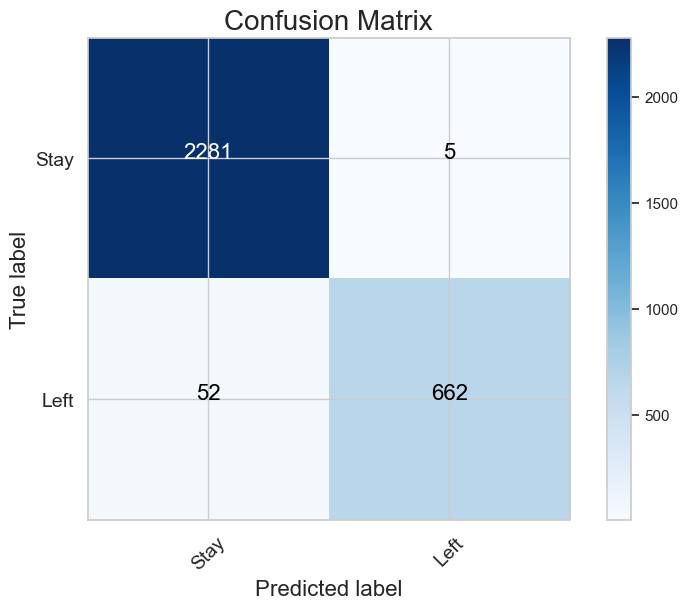

In [ ]:
start_rf = time.time()
rf = RandomForestClassifier(n_jobs=-1, random_state=42).fit(X_train_enc, y_train)
end_rf = time.time()

print("RF (weighted): Training time (seconds):", format(end_rf - start_rf))

y_pred_rf = rf.predict(X_test_enc)

cm_rf = confusion_matrix(y_test, y_pred_rf)

plot_confusion_matrix(cm_rf, class_names)

In [ ]:
print(start + "\nRF Classification Report:" + end)
target_names = ["Stay", "Left"]

report_df = generate_classification_report(y_test, y_pred_rf, target_names)
metrics_df = calculate_performance_metrics(rf, X_test_enc, y_test, y_pred_rf)
full_report_df_rf = pd.concat([report_df, metrics_df], axis=0)
full_report_df_rf


RF Classification Report:


,precision,recall,f1-score,support,ROC AUC,AP,Balanced accuracy,G-mean,Youden's index,MCC
Stay,0.977711,0.997813,0.987660,2286.000,NaN,NaN,NaN,NaN,NaN,NaN
Left,0.992504,0.927171,0.958726,714.000,NaN,NaN,NaN,NaN,NaN,NaN
accuracy,0.981000,0.981000,0.981000,0.981,NaN,NaN,NaN,NaN,NaN,NaN
macro avg,0.985107,0.962492,0.973193,3000.000,NaN,NaN,NaN,NaN,NaN,NaN
weighted avg,0.981232,0.981000,0.980773,3000.000,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,0.99077,0.981834,0.962492,0.961844,0.924984,0.947329


### Model comparison

In [ ]:
full_report_df_lr = pd.DataFrame(full_report_df_lr)
full_report_df_lr.index

Index(['Stay', 'Left', 'accuracy', 'macro avg', 'weighted avg', 'ROC AUC',
       'AP', 'Balanced accuracy', 'G-mean', 'Youden's index', 'MCC',
       'Training_time'],
      dtype='object')

In [ ]:
f1_lr = full_report_df_lr["f1-score"][0]
acc_lr = full_report_df_lr["precision"]["accuracy"]
roc_auc_lr = full_report_df_lr["StandardScaler"]["ROC AUC"]
balanced_acc_lr = full_report_df_lr.loc["Balanced accuracy"]["StandardScaler"]
gmean_lr = full_report_df_lr.loc["G-mean"]["StandardScaler"]
yi_lr = full_report_df_lr.loc["Youden's index"]["StandardScaler"]
mcc_lr = full_report_df_lr.loc["MCC"]["StandardScaler"]

In [ ]:
# DataFrame for model performance metrics
res = pd.DataFrame(
    {
        "Model": ["Logistic Regression", "XGBoost", "LightGBM", "Random Forest"],
        "F1-score": [
            f1_lr,
            full_report_df_xgb["f1-score"]["macro avg"],
            full_report_df_lgb["f1-score"]["macro avg"],
            full_report_df_rf["f1-score"]["macro avg"],
        ],
        "Accuracy": [
            acc_lr,
            full_report_df_xgb["AP"][0],
            full_report_df_lgb["AP"][0],
            full_report_df_rf["AP"][0],
        ],
        "ROC AUC": [
            roc_auc_lr,
            full_report_df_xgb["ROC AUC"][0],
            full_report_df_lgb["ROC AUC"][0],
            full_report_df_rf["ROC AUC"][0],
        ],
        "Balanced accuracy": [
            balanced_acc_lr,
            full_report_df_xgb["Balanced accuracy"][0],
            full_report_df_lgb["Balanced accuracy"][0],
            full_report_df_rf["Balanced accuracy"][0],
        ],
        "Geometric mean (G-mean)": [
            gmean_lr,
            full_report_df_xgb["G-mean"][0],
            full_report_df_lgb["G-mean"][0],
            full_report_df_rf["G-mean"][0],
        ],
        "Youden's index": [
            yi_lr,
            full_report_df_xgb["Youden's index"][0],
            full_report_df_lgb["Youden's index"][0],
            full_report_df_rf["Youden's index"][0],
        ],
        "Matthew’s correlation coefficient (MCC)": [
            mcc_lr,
            full_report_df_xgb["MCC"][0],
            full_report_df_lgb["MCC"][0],
            full_report_df_rf["MCC"][0],
        ],
        "Training_time (seconds)": [
            (end_lr - start_lr),
            (end_xgb - start_xgb),
            (end_lgbmc - start_lgbmc),
            (end_rf - start_rf),
        ],
    }
)

res.sort_values(by=["F1-score", "Training_time (seconds)"], ascending=False)

,Model,F1-score,Accuracy,ROC AUC,Balanced accuracy,Geometric mean (G-mean),Youden's index,Matthew’s correlation coefficient (MCC),Training_time (seconds)
2,LightGBM,0.974366,0.984541,0.992674,0.967745,0.967380,0.935490,0.949086,0.158907
3,Random Forest,0.973193,0.981834,0.990770,0.962492,0.961844,0.924984,0.947329,0.371381
1,XGBoost,0.972187,0.984541,0.992674,0.968096,0.967829,0.936192,0.944509,0.426796
0,Logistic Regression,0.802108,0.724667,0.781394,0.716282,0.716103,0.432564,0.381403,6.689229


## Fine tuning LGBM

In [ ]:
import time
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm


# Custom GridSearchCV for progress visualization
class TqdmGridSearchCV(GridSearchCV):
    def _run_search(self, evaluate_candidates):
        super()._run_search(
            lambda params_list: tqdm(
                evaluate_candidates(params_list), total=len(self.param_grid)
            )
        )


# Load the best parameters if they exist
with open("models/best_lgbm_params.json", "r") as file:
    params = json.load(file)


if params:
    if "class_weight" in params and isinstance(params["class_weight"], dict):
        params["class_weight"] = {int(k): v for k, v in params["class_weight"].items()}

    lgbmc_tuned = LGBMClassifier(**params)
    lgbmc_tuned.fit(X_train_enc, y_train)


else:
    print("No parameters file found or file is empty. Running GridSearchCV instead.")

    # Define parameter grid for LightGBM
    params_lgbm = {
        "num_leaves": [31, 50, 70],
        "max_depth": [5, 10, 15],
        "learning_rate": [0.01, 0.05, 0.1],
        "n_estimators": [100, 200, 300],
        "min_child_samples": [10, 20, 30],
        "class_weight": ["balanced", None, {0: 0.66, 1: 2.10}],
    }

    # Set up the grid search
    grid_lgbm = TqdmGridSearchCV(
        LGBMClassifier(n_jobs=-1, random_state=42),
        param_grid=params_lgbm,
        scoring=["f1"],
        refit="f1",
        n_jobs=-1,
        cv=5,
        verbose=1,
    )

    # Fit the grid search
    start_lgbm_tuned = time.time()
    grid_lgbm.fit(X_train_enc, y_train)
    end_lgbm_tuned = time.time()
    print(
        "LGBM (tuned): Training time (seconds) =",
        format(end_lgbm_tuned - start_lgbm_tuned),
    )

    # Save the best parameters
    dump_params(grid_lgbm.best_estimator_.get_params(), "models/best_lgbm_params.json")

[LightGBM] [Info] Number of positive: 2857, number of negative: 9142
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 664
[LightGBM] [Info] Number of data points in the train set: 11999, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005654
[LightGBM] [Info] Start training from score -0.005654


LGBMClassifier(class_weight={0: 0.66, 1: 2.1}, colsample_bytree=1,
               learning_rate=0.05, max_depth=15, min_child_weight=0.01,
               n_estimators=250, n_jobs=-1, num_leaves=35, random_state=42,
               reg_alpha=0.1, reg_lambda=0.1, subsample=0.8)

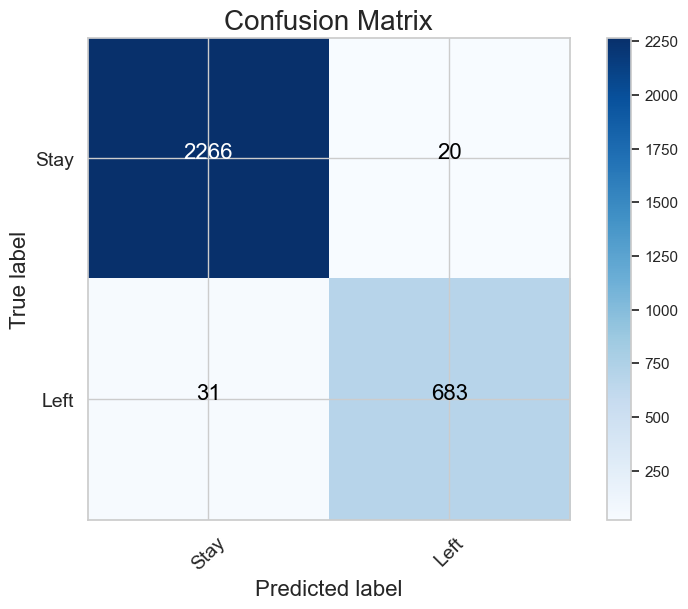

In [ ]:
class_names = ["Stay", "Left"]
y_pred_rf_tuned = lgbmc_tuned.predict(X_test_enc)
cm_rf_tuned = confusion_matrix(y_test, y_pred_rf_tuned)
plot_confusion_matrix(cm_rf_tuned, class_names)

In [ ]:
print("\nClassification report:")
target_names = ["Stay", "Left"]
print(
    classification_report(y_test, y_pred_rf_tuned, target_names=target_names, digits=4)
)

roc_auc_rf_tuned = roc_auc_score(y_test, lgbmc_tuned.predict_proba(X_test_enc)[:, 1])
ap_rf_tuned = average_precision_score(
    y_test, lgbmc_tuned.predict_proba(X_test_enc)[:, 1]
)
balanced_accuracy_rf_tuned = balanced_accuracy_score(y_test, y_pred_rf_tuned)
gmeans_rf_tuned = geometric_mean_score(y_test, y_pred_rf_tuned)
youden_rf_tuned = balanced_accuracy_score(y_test, y_pred_rf_tuned, adjusted=True)
mcc_rf_tuned = matthews_corrcoef(y_test, y_pred_rf_tuned)

print(
    "Area Under the Receiver Operating Characteristic Curve (ROC AUC): {:.5f}".format(
        roc_auc_rf_tuned
    )
)
print(
    "Average precision (AP)                                          : {:.5f}".format(
        ap_rf_tuned
    )
)
print(
    "Balanced accuracy                      : {:.5f}".format(balanced_accuracy_rf_tuned)
)
print("Geometric mean (G-mean)                : {:.5f}".format(gmeans_rf_tuned))
print("Youden's index                         : {:.5f}".format(youden_rf_tuned))
print("Matthew’s correlation coefficient (MCC): {:.5f}".format(mcc_rf_tuned))


Classification report:
              precision    recall  f1-score   support

        Stay     0.9865    0.9913    0.9889      2286
        Left     0.9716    0.9566    0.9640       714

    accuracy                         0.9830      3000
   macro avg     0.9790    0.9739    0.9764      3000
weighted avg     0.9829    0.9830    0.9830      3000

Area Under the Receiver Operating Characteristic Curve (ROC AUC): 0.99239
Average precision (AP)                                          : 0.98561
Balanced accuracy                      : 0.97392
Geometric mean (G-mean)                : 0.97376
Youden's index                         : 0.94783
Matthew’s correlation coefficient (MCC): 0.95293


#### Comparing Train Set vs Test Set

In [ ]:
roc_auc_rf_train = roc_auc_score(y_train, lgbmc_tuned.predict_proba(X_train_enc)[:, 1])
ap_rf_train = average_precision_score(
    y_train, lgbmc_tuned.predict_proba(X_train_enc)[:, 1]
)
balanced_accuracy_rf_train = balanced_accuracy_score(
    y_train, lgbmc_tuned.predict(X_train_enc)
)
gmeans_rf_train = geometric_mean_score(y_train, lgbmc_tuned.predict(X_train_enc))
youden_rf_train = balanced_accuracy_score(
    y_train, lgbmc_tuned.predict(X_train_enc), adjusted=True
)
mcc_rf_train = matthews_corrcoef(y_train, lgbmc_tuned.predict(X_train_enc))

pdf = pd.DataFrame(
    {
        "Model": ["Training set", "Test set"],
        "Area Under the Receiver Operating Characteristic Curve (ROC AUC)": [
            roc_auc_rf_train,
            roc_auc_rf_tuned,
        ],
        "Average precision (AP)": [ap_rf_train, ap_rf_tuned],
        "Balanced accuracy": [balanced_accuracy_rf_train, balanced_accuracy_rf_tuned],
        "Geometric mean (G-mean)": [gmeans_rf_train, gmeans_rf_tuned],
        "Youden's index": [youden_rf_train, youden_rf_tuned],
        "Matthew’s correlation coefficient (MCC)": [mcc_rf_train, mcc_rf_tuned],
    }
)

pd.DataFrame(pdf).set_index("Model").transpose()

del pdf

# Confusion matrix comparison

y_pred_rf_train = lgbmc_tuned.predict(X_train_enc)

train_pdf = pd.DataFrame.from_dict(
    classification_report(
        y_train, y_pred_rf_train, target_names=target_names, digits=4, output_dict=True
    )
).transpose()
tuned_pdf = pd.DataFrame.from_dict(
    classification_report(
        y_test, y_pred_rf_tuned, target_names=target_names, digits=4, output_dict=True
    )
).transpose()

pd.concat([train_pdf, tuned_pdf], axis=1, keys=["Train Set", "Test Set"])

del train_pdf, tuned_pdf

Model,Training set,Test set
Area Under the Receiver Operating Characteristic Curve (ROC AUC),0.999956,0.992389
Average precision (AP),0.999854,0.985606
Balanced accuracy,0.998611,0.973917
Geometric mean (G-mean),0.998611,0.973763
Youden's index,0.997222,0.947834
Matthew’s correlation coefficient (MCC),0.995194,0.952930


Train Set                                   Test Set            \
             precision    recall  f1-score      support precision    recall   
Stay          0.999781  0.997922  0.998850   9142.00000  0.986504  0.991251   
Left          0.993389  0.999300  0.996336   2857.00000  0.971550  0.956583   
accuracy      0.998250  0.998250  0.998250      0.99825  0.983000  0.983000   
macro avg     0.996585  0.998611  0.997593  11999.00000  0.979027  0.973917   
weighted avg  0.998259  0.998250  0.998252  11999.00000  0.982945  0.983000   

                                  
              f1-score   support  
Stay          0.988872  2286.000  
Left          0.964008   714.000  
accuracy      0.983000     0.983  
macro avg     0.976440  3000.000  
weighted avg  0.982954  3000.000

The differences between the training and test set performance metrics are relatively minor, which is a good indication that the model is generalizing well and not overfitting to the training data.

The metrics suggest a robust model with strong predictive power. However, there's always a slight decrease in most metrics from the training to the test set, which is normal as the test set represents new, unseen data for the model.

#### Feature importance

<Axes: xlabel='Importance', ylabel='Feature'>

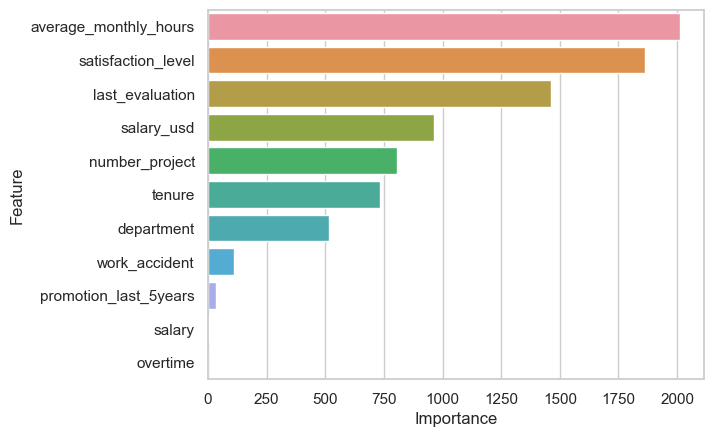

In [ ]:
feature_importances = pd.DataFrame(
    {"Feature": X.columns, "Importance": lgbmc_tuned.feature_importances_}
)
feature_importances = feature_importances.sort_values("Importance", ascending=False)
sns.barplot(x="Importance", y="Feature", data=feature_importances)

In [ ]:
import pickle

filename = "model.sav"
pickle.dump(lgbmc_tuned, open(filename, "wb"))

# Load the model from disk
loaded_model = pickle.load(open(filename, "rb"))
print(loaded_model)

LGBMClassifier(class_weight={0: 0.66, 1: 2.1}, colsample_bytree=1,
               learning_rate=0.05, max_depth=15, min_child_weight=0.01,
               n_estimators=250, n_jobs=-1, num_leaves=35, random_state=42,
               reg_alpha=0.1, reg_lambda=0.1, subsample=0.8)


#### The employees that stayed, but are likely to quit

In [ ]:
stayed = df[df["left"] == 0]
le = LabelEncoder()
stayed["overtime"] = np.where(stayed["average_monthly_hours"] >= 176, 1, 0)
stayed["department"] = le.fit_transform(stayed["department"])

stayed = stayed.drop(["left"], axis=1)

y_pred_risk = loaded_model.predict(stayed)
y_pred_risk.sum()
df[df.index.isin(stayed.index[y_pred_risk == 1])].head(5)

39

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary_usd,salary,overtime
2575,0.80,0.96,3,257,5,0,0,0,support,40270,1,1
2708,0.76,0.93,3,271,5,0,0,0,hr,42871,2,1
3218,0.70,0.88,3,166,5,0,0,0,technical,36661,1,0
3604,0.32,0.97,6,272,2,0,0,0,sales,43955,2,1
3789,0.86,0.96,5,238,5,0,0,0,technical,47158,2,1


In [ ]:
# Predict the risk probabilities
risk_probabilities = loaded_model.predict_proba(stayed)

# Assuming that the risk class is the second one (index 1)
risk_probabilities = risk_probabilities[:, 1]

# Add these probabilities to the original dataframe for analysis
df_stayed_with_risk = df[df.index.isin(stayed.index)].copy()
df_stayed_with_risk["Risk_Probability"] = risk_probabilities

# Display the first 5 instances with their risk probabilities
df_stayed_with_risk.head(5)

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary_usd,salary,overtime,Risk_Probability
634,0.84,0.89,4,187,2,1,0,0,IT,33419,0,1,0.000237
1195,0.77,0.79,3,200,4,0,0,0,hr,39801,1,1,0.024613
1413,0.13,0.72,4,148,5,0,0,0,hr,43912,2,0,0.009826
1739,0.82,0.92,3,187,3,1,0,0,hr,40826,2,1,0.000234
1957,0.88,0.65,4,224,2,0,0,0,hr,45644,2,1,0.001854


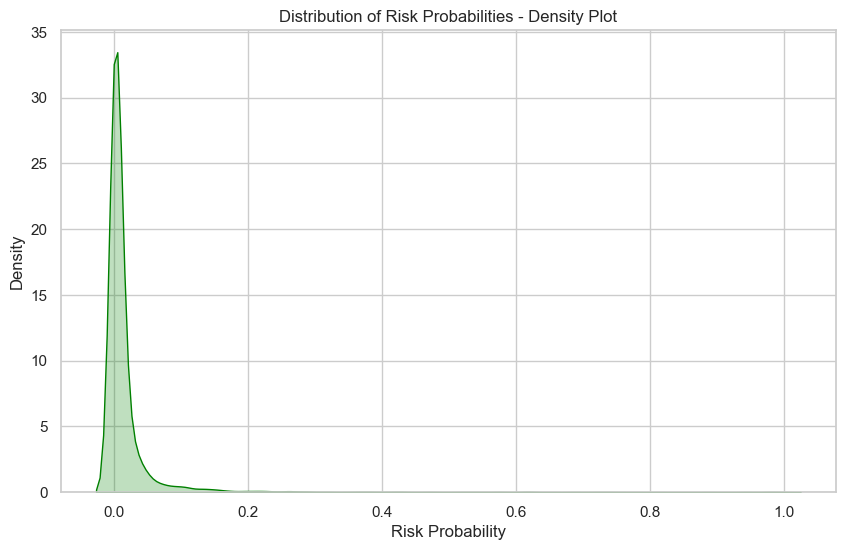

In [ ]:
# Density Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(df_stayed_with_risk["Risk_Probability"], shade=True, color="green")
plt.title("Distribution of Risk Probabilities - Density Plot")
plt.xlabel("Risk Probability")
plt.ylabel("Density")
plt.grid(True)
plt.show();

**Even though the model predicts that 26 employees are likely to quit, the risk is low. Instances with high risk are rare.**

## **Conclusion, Recommendations, Next Steps**


**Conclusion:**

Based on the analysis conducted, we have gained valuable insights into the factors influencing employee retention at Salifort Motors. The random forest model, after hyperparameter tuning, has demonstrated strong performance in predicting employee attrition. The evaluation metrics and classification report indicate high accuracy, precision, recall, and F1-score for both the training and test sets. This suggests that the model generalizes well and can effectively identify employees at risk of leaving the company.

**Recommendations:**

- Enhance Job Satisfaction: Salifort Motors should continuously gauge and improve job satisfaction through feedback and well-being initiatives.

- Competitive Compensation: Maintain industry-competitive salaries and offer performance incentives to keep and attract skilled employees.

- Data-Driven Decisions: Expand data collection to refine the turnover prediction model and highlight actionable retention strategies.

- Workload Oversight: Monitor and adjust employee workloads to prevent burnout, ensuring that overtime is both fair and compensated.
- Work-Life Harmony: Implement flexible and innovative work arrangements to bolster work-life balance, such as hybrid or reduced-hour schedules.
- Utilize Analytics: Use predictive analytics in conjunction with HR tools for proactive retention management.
- Invest in Development: Prioritize training programs to boost proficiency and job satisfaction, mitigating turnover.





